Mean sampling rate: 255.60 Hz
Median sampling rate: 253.00 Hz


/var/folders/dh/551p960n6mv9t9byzj8pp0640000gp/T/ipykernel_11459/3966875533.py:14: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df["RoundedTime"] = df["TimeStamp"].dt.floor("S")  # 'S' means second


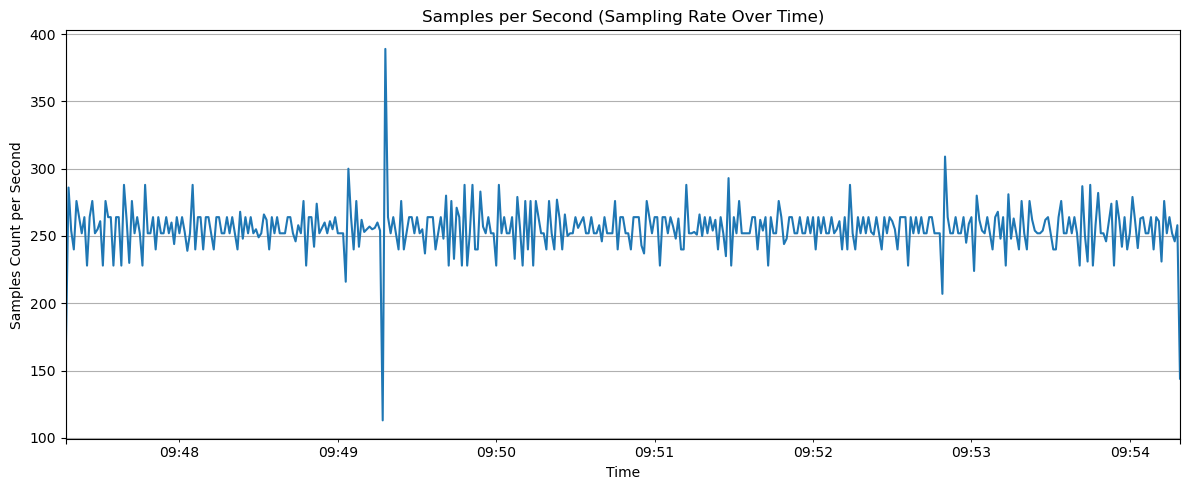

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("data/data.csv")

# Convert TimeStamp to datetime
df["TimeStamp"] = pd.to_datetime(df["TimeStamp"], errors="coerce")

# Drop rows with invalid timestamps
df = df.dropna(subset=["TimeStamp"])

# Round each timestamp to the nearest second
df["RoundedTime"] = df["TimeStamp"].dt.floor("S")  # 'S' means second

# Count how many samples per second
samples_per_second = df.groupby("RoundedTime").size()

# Print mean and median sampling rate
print(f"Mean sampling rate: {samples_per_second.mean():.2f} Hz")
print(f"Median sampling rate: {samples_per_second.median():.2f} Hz")

# Optional: Plot the per-second sampling frequency
plt.figure(figsize=(12, 5))
samples_per_second.plot()
plt.title("Samples per Second (Sampling Rate Over Time)")
plt.xlabel("Time")
plt.ylabel("Samples Count per Second")
plt.grid(True)
plt.tight_layout()
plt.show()


In [35]:
import pandas as pd
import numpy as np

# Parameters
sampling_rate = 255  # Hz
skip_duration = 1  # seconds
window_duration = 1  # seconds
skip_rows = skip_duration * sampling_rate
window_size = window_duration * sampling_rate

# EEG columns of interest
eeg_columns = [
    "Delta_TP9",
    "Delta_AF7",
    "Delta_AF8",
    "Delta_TP10",
    "Theta_TP9",
    "Theta_AF7",
    "Theta_AF8",
    "Theta_TP10",
    "Alpha_TP9",
    "Alpha_AF7",
    "Alpha_AF8",
    "Alpha_TP10",
    "Beta_TP9",
    "Beta_AF7",
    "Beta_AF8",
    "Beta_TP10",
    "Gamma_TP9",
    "Gamma_AF7",
    "Gamma_AF8",
    "Gamma_TP10",
]

# Load CSV into pandas DataFrame
df = pd.read_csv(
    "data/data.csv",
    skip_blank_lines=True,
)

# Drop rows where EEG data is missing
df = df.dropna(subset=eeg_columns)

# Fill NaNs with 0 in case some EEG columns are sparsely empty
df[eeg_columns] = df[eeg_columns].fillna(0).astype(float)

# Reset index for safe slicing
df = df.reset_index(drop=True)

# Store samples and labels
data_windows = []
labels = []

# Scan for markers and extract windows
for i in range(len(df) - window_size - skip_rows):
    element = str(df.loc[i, "Elements"]) if "Elements" in df.columns else ""

    if "/Marker/1" in element:
        label = 0
    elif "/Marker/2" in element:
        label = 1
    else:
        continue

    start = i + skip_rows
    end = start + window_size

    if end <= len(df):
        window = df.loc[start : end - 1, eeg_columns].values
        if window.shape[0] == window_size:
            data_windows.append(window)
            labels.append(label)

# Convert to NumPy arrays
X = np.array(data_windows)  # shape: [samples, window_size, features]
y = np.array(labels)

# Flatten time dimension if needed for ML models
X_flat = X.reshape(X.shape[0], -1)

# Save as DataFrame
output_df = pd.DataFrame(X_flat)
output_df["label"] = y
output_df.to_csv("processed_eeg_windows.csv", index=False)

print(f"✅ Extracted {len(output_df)} labeled samples to processed_eeg_windows.csv")


ValueError: cannot reshape array of size 0 into shape (0,newaxis)

In [76]:
import pandas as pd
import numpy as np

# Parameters
sampling_rate = 255  # Hz
skip_duration = 1  # seconds after marker
window_duration = 1  # seconds to collect
skip_rows = skip_duration * sampling_rate
window_size = window_duration * sampling_rate

# EEG columns of interest
eeg_columns = [
    "Delta_TP9",
    "Delta_AF7",
    "Delta_AF8",
    "Delta_TP10",
    "Theta_TP9",
    "Theta_AF7",
    "Theta_AF8",
    "Theta_TP10",
    "Alpha_TP9",
    "Alpha_AF7",
    "Alpha_AF8",
    "Alpha_TP10",
    "Beta_TP9",
    "Beta_AF7",
    "Beta_AF8",
    "Beta_TP10",
    "Gamma_TP9",
    "Gamma_AF7",
    "Gamma_AF8",
    "Gamma_TP10",
]

# Load CSV into pandas DataFrame
df = pd.read_csv("data/data.csv", skip_blank_lines=True)

# Convert EEG columns to numeric (non-numeric values become NaN)
df[eeg_columns] = df[eeg_columns].apply(pd.to_numeric, errors="coerce")

# Reset index for safe slicing
df = df.reset_index(drop=True)

data_windows_0 = []  # For marker 1 (left)
data_windows_1 = []  # For marker 2 (right)
X = []  # Flattened windows
y = []  # Labels

# Scan for markers
for i in range(len(df) - window_size - skip_rows):
    # Check if the 41st column (index 40) contains a marker
    marker_cell = df.iloc[i, 40]
    if pd.isna(marker_cell) or not isinstance(marker_cell, str):
        continue

    marker = marker_cell.strip()

    if "/Marker/1" in marker:
        label = 0  # Left
    elif "/Marker/2" in marker:
        label = 1  # Right
    else:
        continue  # Ignore other markers

    # Define start and end index for the EEG window
    start = i + skip_rows
    end = start + window_size

    eeg_window = df.loc[start : end - 1, eeg_columns].values  # shape (255, 20)

    # Store by class
    if label == 0:
        data_windows_0.append(eeg_window)
    elif label == 1:
        data_windows_1.append(eeg_window)

    # Flatten and add label at front for ML-ready format
    flattened = eeg_window.flatten()
    X.append(flattened)
    y.append(label)


# Convert separated windows to arrays if needed later
data_windows_0 = np.array(data_windows_0)  # Shape: (N0, 255, 20)
data_windows_1 = np.array(data_windows_1)  # Shape: (N1, 255, 20)

In [ ]:
import pandas as pd
import numpy as np
from scipy.signal import butter, lfilter

# Parameters
sampling_rate = 255  # Hz
skip_duration = 1  # seconds after marker
window_duration = 1  # seconds to collect
skip_rows = skip_duration * sampling_rate
window_size = window_duration * sampling_rate

lowcut = (8.0,)
highcut = 30.0


# EEG columns of interest
eeg_columns = [
    "Delta_TP9",
    "Delta_AF7",
    "Delta_AF8",
    "Delta_TP10",
    "Theta_TP9",
    "Theta_AF7",
    "Theta_AF8",
    "Theta_TP10",
    "Alpha_TP9",
    "Alpha_AF7",
    "Alpha_AF8",
    "Alpha_TP10",
    "Beta_TP9",
    "Beta_AF7",
    "Beta_AF8",
    "Beta_TP10",
    "Gamma_TP9",
    "Gamma_AF7",
    "Gamma_AF8",
    "Gamma_TP10",
]


# Bandpass filter: 8–30 Hz for motor imagery
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    return butter(order, [low, high], btype="band")


def apply_bandpass_filter(data, lowcut=lowcut, highcut=highcut, fs=sampling_rate):
    b, a = butter_bandpass(lowcut, highcut, fs)
    return lfilter(b, a, data, axis=0)  # Apply filter along time axis (rows)


# Load and preprocess CSV
df = pd.read_csv("data/data.csv", skip_blank_lines=True)
df[eeg_columns] = df[eeg_columns].apply(pd.to_numeric, errors="coerce")
df = df.reset_index(drop=True)

X = []  # Flattened windows
y = []  # Labels

# Scan for markers
for i in range(len(df) - window_size - skip_rows):
    marker_cell = df.iloc[i, 40]
    if pd.isna(marker_cell) or not isinstance(marker_cell, str):
        continue

    marker = marker_cell.strip()

    if "/Marker/1" in marker:
        label = 0
    elif "/Marker/2" in marker:
        label = 1
    else:
        continue

    # Get EEG window
    start = i + skip_rows
    end = start + window_size
    eeg_window = df.loc[start : end - 1, eeg_columns].values  # shape: (255, 20)

    # Skip if the window contains NaNs or Infs (contaminated window)
    if not np.all(np.isfinite(eeg_window)):
        continue

    # Apply bandpass filter to the window (along rows)
    eeg_window_filtered = apply_bandpass_filter(eeg_window)

    # Flatten the window into a vector
    flattened = eeg_window_filtered.flatten()
    X.append(flattened)
    y.append(label)

# Convert to arrays
X = np.array(X)  # Shape: (num_windows, 255*20)
y = np.array(y)  # Shape: (num_windows,)

print(f"Extracted {len(X)} windows. X shape: {X.shape}, y shape: {y.shape}")


Extracted 7 windows. X shape: (7, 5100), y shape: (7,)
